In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
random_state = 42

import python_code.Scripts as sc
import python_code.Reference as ref
import pickle

from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,recall_score,precision_score
from treeinterpreter import treeinterpreter as ti
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv("./data/final.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FSASSET   3904 non-null   float64
 1   FSSLTDE2  3904 non-null   float64
 2   RAWERND   3904 non-null   float64
 3   SHELDED   3904 non-null   float64
 4   FSNONCIT  3904 non-null   float64
 5   CERTHHSZ  3904 non-null   float64
 6   WRK_POOR  3904 non-null   float64
 7   FSERNDED  3904 non-null   float64
 8   FSNETINC  3904 non-null   float64
 9   FSERNDE2  3904 non-null   float64
 10  FSUSIZE   3904 non-null   float64
 11  FSSSI     3904 non-null   float64
 12  TANF_IND  3904 non-null   float64
 13  REALPROP  3904 non-null   float64
 14  LIQRESOR  3904 non-null   float64
 15  FSWAGES   3904 non-null   float64
 16  FSCSEXP   3904 non-null   float64
 17  FSSTDDE2  3904 non-null   float64
 18  FSDIS     3904 non-null   float64
 19  FSSLTDED  3904 non-null   float64
 20  TPOV      3904 non-null   floa

In [5]:
TARGET_COL = "CAT_ELIG"
X = df.drop(columns = ['CAT_ELIG'])
#y = df['CAT_ELIG']
y = df[TARGET_COL].replace({2: 0, 1: 1}).astype('int8')

In [6]:
#baseline, NULL Model
y.value_counts(normalize=True)

CAT_ELIG
1    0.625512
0    0.374488
Name: proportion, dtype: float64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=random_state)

In [8]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [9]:
np.savetxt('./data/TrainTest/X_train.csv',X_train,delimiter=',')
np.savetxt('./data/TrainTest/y_train.csv',y_train,delimiter=',')
np.savetxt('./data/TrainTest/X_test.csv',X_test,delimiter=',')
np.savetxt('./data/TrainTest/y_test.csv',y_test,delimiter=',')

In [10]:
pca = PCA(n_components=10,random_state=42)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)

In [11]:
models = {
    'LogReg': LogisticRegression(),
    'Decision Tree':DecisionTreeClassifier(),
    'Random Forest':RandomForestClassifier(),
    'Gradient Boost':GradientBoostingClassifier(),
    'Ada Boost':AdaBoostClassifier(),
    'SVC':SVC(),
    'Naive Bayes':GaussianNB()}

In [12]:
#adapted from Dan Brown lecture
final = pd.DataFrame(columns = ['cross_val_train','cross_val_test','test_recall','test_precision'])
idx=0
while idx < len(models.keys()):
    for name,model in models.items():
        results = {}
        results['name']=name
        name=model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        results['cross_val_train'] = np.mean(cross_val_score(model,X_train,y_train,cv=4))
        results['cross_val_test'] = np.mean(cross_val_score(model,X_test,y_test,cv=4))
        results['test_recall'] = recall_score(y_test, y_pred_test)
        results['test_precision'] = precision_score(y_test, y_pred_test)
        final = pd.concat([final, pd.DataFrame([results])], ignore_index=True)
        idx+=1

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17816\3752060610.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, pd.DataFrame([results])], ignore_index=True)


In [13]:
# Version 1 known good but not correct
# Build one row per model, then make the DataFrame once
#cv4 = StratifiedKFold(n_splits=4, shuffle=False)

#final = pd.DataFrame(columns=['name','cross_val_train','cross_val_test','test_recall','test_precision'])
#idx=0
#while idx < len(models.keys()):
#    for name, model in models.items():
#        results = {}
    
#        results['name'] = name
#        model.fit(X_train, y_train)
    
#        y_pred_test = model.predict(X_test)
    
#        results['cross_val_train'] = np.mean(cross_val_score(model, X_train, y_train, cv=cv4))
#        results['cross_val_test']  = np.mean(cross_val_score(model,  X_test,  y_test,  cv=cv4))
#        results['test_recall']     = recall_score(y_test, y_pred_test)        # add average='macro' if multiclass
#        results['test_precision']  = precision_score(y_test, y_pred_test)     # add average='macro' if multiclass
    
        # modern replacement for .append:
#        final.loc[len(final)] = results
#        idx+=1

In [14]:
final = final.set_index('name')
final

,cross_val_train,cross_val_test,test_recall,test_precision
name,,,,
LogReg,0.799780,0.774744,0.882920,0.784578
Decision Tree,0.863104,0.872867,0.889807,0.907303
Random Forest,0.889458,0.902730,0.929752,0.917120
Gradient Boost,0.889458,0.897611,0.921488,0.920220
Ada Boost,0.848097,0.827645,0.904959,0.858824
SVC,0.812958,0.768771,0.928375,0.799526
Naive Bayes,0.678258,0.655290,0.803030,0.741730


In [15]:
#Version 1 known good but incorrect
#pc_final = pd.DataFrame(columns=['name','cross_val_train','cross_val_test','test_recall','test_precision'])
#idx=0
#while idx < len(models.keys()):
#    for name, model in models.items():
#        results = {}
    
#        results['name'] = name
#        model.fit(X_train_pc, y_train)
    
#        y_pred_test = model.predict(X_test_pc)
    
#        results['cross_val_train'] = np.mean(cross_val_score(model, X_train_pc, y_train, cv=cv4))
#        results['cross_val_test']  = np.mean(cross_val_score(model,  X_test_pc,  y_test,  cv=cv4))
#        results['test_recall']     = recall_score(y_test, y_pred_test)        # add average='macro' if multiclass
#        results['test_precision']  = precision_score(y_test, y_pred_test)     # add average='macro' if multiclass
    
        # replacement for .append:
#        pc_final.loc[len(pc_final)] = results
#        idx+=1

In [16]:
pc_final = pd.DataFrame(columns = ['cross_val_train','cross_val_test','test_recall','test_precision'])
idx=0
while idx < len(models.keys()):
    for name,model in models.items():
        results = {}
        results['name']=name
        name=model.fit(X_train_pc, y_train)
        y_pred_train = model.predict(X_train_pc)
        y_pred_test = model.predict(X_test_pc)
        results['cross_val_train'] = np.mean(cross_val_score(model,X_train_pc,y_train,cv=4))
        results['cross_val_test'] = np.mean(cross_val_score(model,X_test_pc,y_test,cv=4))
        results['test_recall'] = recall_score(y_test, y_pred_test)
        results['test_precision'] = precision_score(y_test, y_pred_test)
        pc_final = pd.concat([pc_final, pd.DataFrame([results])], ignore_index=True)
        idx+=1

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17816\2782522977.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pc_final = pd.concat([pc_final, pd.DataFrame([results])], ignore_index=True)


In [17]:
pc_final = pc_final.set_index('name')
pc_final

,cross_val_train,cross_val_test,test_recall,test_precision
name,,,,
LogReg,0.730966,0.721843,0.895317,0.723026
Decision Tree,0.748902,0.736348,0.822314,0.794940
Random Forest,0.805637,0.770478,0.882920,0.819693
Gradient Boost,0.793558,0.796075,0.870523,0.793970
Ada Boost,0.768668,0.761092,0.852617,0.777638
SVC,0.745608,0.742321,0.918733,0.737832
Naive Bayes,0.690337,0.676621,0.926997,0.674349


In [18]:
for name,model in models.items():
    name = model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred_test))
    print('\n')

LogisticRegression()
              precision    recall  f1-score   support

           0       0.76      0.61      0.67       446
           1       0.78      0.88      0.83       726

    accuracy                           0.78      1172
   macro avg       0.77      0.74      0.75      1172
weighted avg       0.78      0.78      0.77      1172



DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       446
           1       0.90      0.89      0.90       726

    accuracy                           0.87      1172
   macro avg       0.87      0.87      0.87      1172
weighted avg       0.88      0.87      0.87      1172



RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       446
           1       0.92      0.93      0.92       726

    accuracy                           0.90      1172
   macro avg       0.90      0.89      0.90      1172

In [19]:
rf = RandomForestClassifier()
params={'max_depth':[None,3,4],
       'max_features':[None,'sqrt'],
       'n_estimators':[75,100,125]}
rf_gs = GridSearchCV(rf,param_grid=params)
rf_gs.fit(X_train,y_train)
print(rf_gs.best_score_)
rf_gs.best_params_

0.9066623808854157


{'max_depth': None, 'max_features': None, 'n_estimators': 125}

In [20]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [21]:
instances = X_test[[735]]
instances

array([[-0.24309398, -0.87253073, -0.59885312,  1.00652396,  1.78070948,
         1.02614408, -0.76825854, -0.59758589, -0.8826584 , -0.56404251,
         1.02614408, -0.42833737, -0.36488324, -0.03517855, -0.24501332,
        -0.55893964, -0.11792301, -1.59315573, -0.51403261,  1.0459183 ,
        -1.49056789,  0.86481274,  0.39411313, -0.12096324, -0.91848291,
        -0.1335093 , -0.59800159, -0.34230342, -0.88061189, -0.40909055,
        -0.02833014, -0.42334304]])

In [22]:
ft_list = []
prediction, bias, contributions = ti.predict(rf, instances)
print( "Prediction", prediction)
print( "Bias (trainset prior)", bias)
print ("Feature contributions:")
for c, feature in zip(contributions[0], 
                             X.columns):
    ft_list.append((feature, np.round(c, 2)))
    print (feature, c)
    
labels, values = zip(*ft_list)

Prediction [[0.76 0.24]]
Bias (trainset prior) [[0.37148243 0.62851757]]
Feature contributions:
FSASSET [-0.02885533  0.02885533]
FSSLTDE2 [-0.0065806  0.0065806]
RAWERND [-0.01670758  0.01670758]
SHELDED [ 0.2551356 -0.2551356]
FSNONCIT [ 0.02655909 -0.02655909]
CERTHHSZ [-0.02611993  0.02611993]
WRK_POOR [-0.01578029  0.01578029]
FSERNDED [-0.00926313  0.00926313]
FSNETINC [ 0.0001726 -0.0001726]
FSERNDE2 [-0.00598226  0.00598226]
FSUSIZE [-0.02538734  0.02538734]
FSSSI [ 0.01926778 -0.01926778]
TANF_IND [ 0.0273254 -0.0273254]
REALPROP [0. 0.]
LIQRESOR [-0.03605594  0.03605594]
FSWAGES [-0.00903801  0.00903801]
FSCSEXP [-9.46864223e-05  9.46864223e-05]
FSSTDDE2 [ 0.03930851 -0.03930851]
FSDIS [-0.00033265  0.00033265]
FSSLTDED [ 0.16085864 -0.16085864]
TPOV [-0.00337744  0.00337744]
FSNK0T4 [ 0.02007599 -0.02007599]
FSTOTDED [-0.02368809  0.02368809]
FSOTHUN [-0.00081323  0.00081323]
FSUNEARN [ 0.02929817 -0.02929817]
FSGA [ 0.0027453 -0.0027453]
FSEARN [-0.02065551  0.02065551]
FST

In [23]:
df1 = pd.DataFrame(ft_list,columns=['feature','array'])
df2 = pd.DataFrame(df1["array"].to_list(), columns=['pred_0', 'pred_1'])
coef_df = pd.concat([df1,df2],axis=1).drop(columns=['array'])
coef_df.to_csv('./data/2018_indicators/coef.csv',index=None)

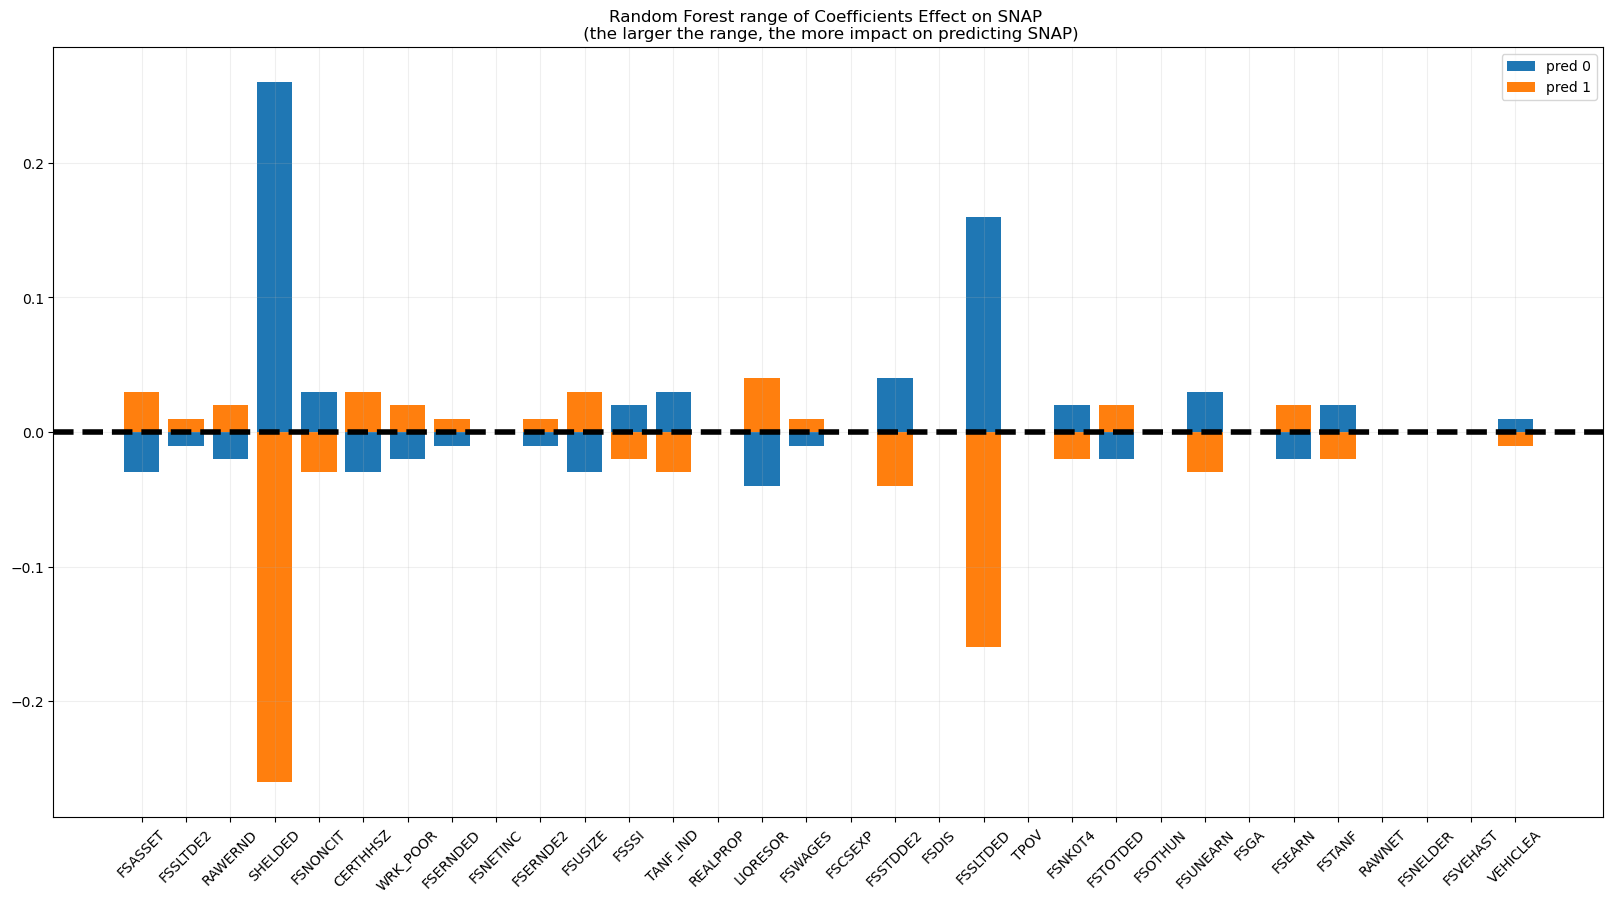

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title('Random Forest range of Coefficients Effect on SNAP \n (the larger the range, the more impact on predicting SNAP)')
plt.grid(zorder=0,alpha = 0.2)
xs = np.arange(len(labels))
ax.bar(xs,coef_df['pred_0'], label = 'pred 0')
ax.bar(xs,coef_df['pred_1'],label = 'pred 1')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.set_xticks(coef_df.index)
ax.set_xticklabels(coef_df['feature'],rotation = 45)
plt.legend()
plt.savefig('./images/rf_corr.png');

In [25]:
et = ExtraTreeClassifier()
params={'max_depth':[None,3,4],
       'max_features':[None,'sqrt'],
       'max_leaf_nodes':[5,10]}
et_gs = GridSearchCV(et,param_grid=params)
et_gs.fit(X_train,y_train)
print(et_gs.best_score_)
et_gs.best_params_

0.7580435408588974


{'max_depth': None, 'max_features': None, 'max_leaf_nodes': 10}

In [26]:
bag = BaggingClassifier()
bag.fit(X_train,y_train)
y_pred_train = bag.predict(X_train)
y_pred_test = bag.predict(X_test)
print(f'cross_val_train = {np.mean(cross_val_score(model,X_train_pc,y_train,cv=4))}')
print(f'cross_val_test = {np.mean(cross_val_score(model,X_test_pc,y_test,cv=4))}')
print(f'test_recall = {recall_score(y_test, y_pred_test)}')
print(f'test_precision = {precision_score(y_test, y_pred_test)}')

cross_val_train = 0.6903367496339678
cross_val_test = 0.6766211604095563
test_recall = 0.9077134986225895
test_precision = 0.928169014084507


In [27]:
vote = VotingClassifier([
    ('rf',RandomForestClassifier(bootstrap=False,n_estimators=1000)),
    ('gb',GradientBoostingClassifier(max_depth=10,subsample=0.8)),
    ('bag',BaggingClassifier(n_estimators = 10))
])

In [28]:
vote.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     n_estimators=1000)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=10,
                                                         subsample=0.8)),
                             ('bag', BaggingClassifier())])

In [29]:
filename = 'final_model.sav'
pickle.dump(vote, open(filename, 'wb'))